In [1]:
!set -e 

!mkdir -p datasets
!cd datasets
!wget http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
!tar xvf profiledata_06-May-2005.tar.gz
!mv profiledata_06-May-2005/* datasets/
!rm -r profiledata_06-May-2005

--2022-02-23 07:35:40--  http://www.iro.umontreal.ca/~lisa/datasets/profiledata_06-May-2005.tar.gz
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135880312 (130M) [application/x-gzip]
Saving to: ‘profiledata_06-May-2005.tar.gz’

profiledata_06-May- 100%[===================>] 129.58M  35.0MB/s    in 4.2s    

2022-02-23 07:35:45 (31.0 MB/s) - ‘profiledata_06-May-2005.tar.gz’ saved [135880312/135880312]

profiledata_06-May-2005/
profiledata_06-May-2005/artist_data.txt
profiledata_06-May-2005/README.txt
profiledata_06-May-2005/user_artist_data.txt
profiledata_06-May-2005/artist_alias.txt


In [8]:
!cat datasets/user_artist_data.txt |head

1000002 1 55
1000002 1000006 33
1000002 1000007 8
1000002 1000009 144
1000002 1000010 314
1000002 1000013 8
1000002 1000014 42
1000002 1000017 69
1000002 1000024 329
1000002 1000025 1
cat: write error: Broken pipe


In [9]:
!cat datasets/artist_data.txt |head

1134999	06Crazy Life
6821360	Pang Nakarin
10113088	Terfel, Bartoli- Mozart: Don
10151459	The Flaming Sidebur
6826647	Bodenstandig 3000
10186265	Jota Quest e Ivete Sangalo
6828986	Toto_XX (1977
10236364	U.S Bombs -
1135000	artist formaly know as Mat
10299728	Kassierer - Musik für beide Ohren
cat: write error: Broken pipe


In [10]:
!cat datasets/artist_alias.txt |head

1092764	1000311
1095122	1000557
6708070	1007267
10088054	1042317
1195917	1042317
1112006	1000557
1187350	1294511
1116694	1327092
6793225	1042317
1079959	1000557
cat: write error: Broken pipe


In [14]:
!pip install pyspark==2.4.5

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 217.8 MB 77.1 MB/s eta 0:00:01                      | 18.2 MB 15.1 MB/s eta 0:00:14                       | 20.5 MB 15.1 MB/s eta 0:00:14 MB 15.1 MB/s eta 0:00:13 |████▌                           | 30.4 MB 15.1 MB/s eta 0:00:13
     |████████████████████████████████| 197 kB 64.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257928 sha256=27a5da733f070c1bd17f37da7b78f2ee7274a55fd6318edddb9ed575c9dfdfeb
  Stored in directory: /tmp/wsuser/.cache/pip/whe

In [20]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

22/02/23 07:57:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [21]:
import os, sys
import re
import random

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

In [22]:
sqlContext = SQLContext(sc)

In [27]:
directory_path = "datasets/"

In [28]:
userArtistDataSchema = StructType([
    StructField("userID", LongType(), True),
    StructField("artistID", LongType(), True),
    StructField("playcount", IntegerType(), True)
])

userArtistDF = sqlContext.read.format('com.databricks.spark.csv').options(header='false', delimiter=' ').load(directory_path + 'user_artist_data.txt', schema=userArtistDataSchema).cache()

In [29]:
userArtistDF.show()

[Stage 0:>                                                          (0 + 1) / 1]

+-------+--------+---------+
| userID|artistID|playcount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



In [32]:
totalUsers = userArtistDF.count()
print(" total number of users : {}".format(totalUsers))
distinctUsers = userArtistDF.select('userID').distinct().count()
print(" total number of distinct users : {}".format(distinctUsers))

 total number of users : 24296858


[Stage 8:===============================================>       (174 + 2) / 200]

 total number of distinct users : 148111


In [33]:
distinctArtists = userArtistDF.select('artistID').distinct().count()
print(" total number of distinct artists : {}".format(distinctUsers))

[Stage 11:=================================================>    (183 + 2) / 200]

 total number of distinct artists : 148111


In [39]:
MAX_ID =  2147483647
negativeUserID = userArtistDF[(userArtistDF.userID.cast('int') < 0)]
print(" negative ID : {}".format(negativeUserID.show()))
invalidUserID = userArtistDF[(userArtistDF.userID.cast('int') > MAX_ID)]
print(" invalid ID : {}".format(invalidUserID.show()))

+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 negative ID : None
+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 invalid ID : None


In [38]:
userArtistDF.select('userID').describe().show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551820078|
|    min|                90|
|    max|           2443548|
+-------+------------------+



In [40]:
negativeArtistID = userArtistDF[(userArtistDF.userID.cast('int') < 0)]
print(" negative ID : {}".format(negativeArtistID.show()))
invalidArtistID = userArtistDF[(userArtistDF.userID.cast('int') > MAX_ID)]
print(" invalid ID : {}".format(invalidArtistID.show()))

+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 negative ID : None
+------+--------+---------+
|userID|artistID|playcount|
+------+--------+---------+
+------+--------+---------+

 invalid ID : None


In [41]:
userArtistDF.select('artistID').describe().show()

+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev|2539389.0924284607|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



In [44]:
maxUserID = userArtistDF.agg({'userID' : 'max'}).show() 
maxUserID = userArtistDF.agg({'userID' : 'min'}).show() 
maxUserID = userArtistDF.agg({'artistID' : 'max'}).show() 
maxUserID = userArtistDF.agg({'artistID' : 'min'}).show() 

+-----------+
|max(userID)|
+-----------+
|    2443548|
+-----------+

+-----------+
|min(userID)|
+-----------+
|         90|
+-----------+

+-------------+
|max(artistID)|
+-------------+
|     10794401|
+-------------+

+-------------+
|min(artistID)|
+-------------+
|            1|
+-------------+



# Some Statistics

In [49]:
userActivity = userArtistDF.groupBy('userID').sum('playCount').collect()
userActivity[:5]

[Row(userID=1000061, sum(playCount)=244),
 Row(userID=1000070, sum(playCount)=20200),
 Row(userID=1000313, sum(playCount)=201),
 Row(userID=1000832, sum(playCount)=1064),
 Row(userID=1000905, sum(playCount)=214)]

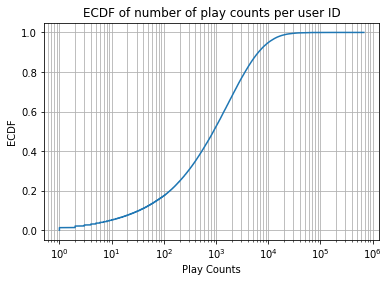

Sum = 371638969
Mean = 2509.1922206993404
Max = 674412
Min = 1
Percentile 25% = 204.0
Percentile 50% = 892.0
Percentile 75% = 2800.0
Percentile 90% = 6484.0
Percentile 95% = 10120.0
Percentile 97% = 13297.399999999965
The percentage of users who listen less than 10 times P(Y<=10) = 5.229%


In [56]:
pdf = pd.DataFrame(data=userActivity)
Y = np.sort(pdf[1])
Yvals = np.arange(len(Y)) / float(len(Y))

plt.semilogx(Y, Yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True, which='both', ls="-")
plt.title('ECDF of number of play counts per user ID')
plt.show()

print('Sum = {}'.format(Y.sum()))
print('Mean = {}'.format(Y.mean()))
print('Max = {}'.format(Y.max()))
print('Min = {}'.format(Y.min()))

print('Percentile 25% = {}'.format(np.percentile(Y, 25)))
print('Percentile 50% = {}'.format(np.percentile(Y, 50)))
print('Percentile 75% = {}'.format(np.percentile(Y, 75)))
print('Percentile 90% = {}'.format(np.percentile(Y, 90)))
print('Percentile 95% = {}'.format(np.percentile(Y, 95)))
print('Percentile 97% = {}'.format(np.percentile(Y, 97)))

print('The percentage of users who listen less than 10 times P(Y<=10) = {:.3f}%'.format(len(Y[Y<=10])*100 / len(Y)))